### Using COLMAP Structure From Motion (SFM) Package

see <https://github.com/Fyusion/LLFF/tree/master> for more documentation

In [1]:
from pillow_heif import register_heif_opener
from matplotlib import pyplot as plt
import numpy as np
import os
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from PIL import Image

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

tf.compat.v1.enable_eager_execution()


2024-03-11 14:20:15.454931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 14:20:15.553353: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 14:20:15.918435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-11 14:20:15.918478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-11 14:20:16.476374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-11 14:20:16.495751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-11 14:20:16.495880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
#loop through subdirectory and convert each .HEIC to similarly named .PNG
register_heif_opener()
rootdir = 'desk_images'
# rootdir = 'bike_images'

mega_image_array = np.zeros([0,1000,1000,3])

for subdir, dirs, files in os.walk(rootdir):
    for file in sorted(files):
        if file.endswith(("HEIC")):
            print(file)
            image_i = Image.open(rootdir+'/'+file)
            i = np.asarray(image_i)
            #crop square ~~~~~~~~~~~~~~~~
            if np.shape(i)[0] > np.shape(i)[1]:
                i = i[516:-516,12:-12,:]
            else:
                i = i[12:-12,516:-516,:]
#             i = i[::8,::8,:] #was this
            #this gets us straight to a 250x250
            i = i[::12,::12,:]
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#             mega_image_array = np.append(mega_image_array, i[None,:,:,:], axis = 0)
            im = Image.fromarray(i)
            im.save(rootdir+"/"+file[:-5]+'.png')
#             os.remove(file) #remove HEIC image

#             #only save landscape images
#             if np.shape(i)[0] < np.shape(i)[1]:
#                 i = i[::8,::8,:]
#                 im = Image.fromarray(i)
#                 im.save(rootdir+"/"+file[:-5]+'.png')

# np.savez_compressed("desk_images", mega_image_array)

IMG_2072.HEIC
IMG_2073.HEIC
IMG_2074.HEIC
IMG_2075.HEIC
IMG_2076.HEIC
IMG_2077.HEIC
IMG_2078.HEIC
IMG_2079.HEIC
IMG_2080.HEIC


/tmp/ipykernel_26783/224248354.py:13: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'HeifImageFile'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  i = np.asarray(image_i)

KeyboardInterrupt



In [3]:
#load poses estimated by COLMAP

images_from_colmap = read_images_text("sparseDesk/sparse/0/images.txt")
cameras = read_cameras_text("sparseDesk/sparse/0/cameras.txt")
pts3d = read_points3D_text("sparseDesk/sparse/0/points3D.txt")
# images_from_colmap = read_images_text("sparseBike/sparse/0/images.txt")
# cameras = read_cameras_text("sparseBike/sparse/0/cameras.txt")
# pts3d = read_points3D_text("sparseBike/sparse/0/points3D.txt")

print(images_from_colmap[1])
# print(pts3d[1])
print(len(cameras))
print("\n",cameras[10])

Image(id=1, qvec=array([ 0.987349 , -0.0203818, -0.133278 , -0.0834504]), tvec=array([ 4.19723, -0.92331,  1.27549]), camera_id=1, name='IMG_2072.png', xys=array([[  18.85   ,    6.20901],
       [ 236.338  ,   11.7041 ],
       [ 259.738  ,   12.5039 ],
       ...,
       [1648.67   , 2964.93   ],
       [2196.78   , 3495.46   ],
       [1116.     ,  765.455  ]]), point3D_ids=array([   -1,    -1,    -1, ..., 20131,    -1,    -1]))
89

 Camera(id=10, model='SIMPLE_RADIAL', width=3024, height=4032, params=array([3.12499e+03, 1.51200e+03, 2.01600e+03, 6.31330e-02]))


In [4]:
#convert COLMAP poses (xyz,quats) to rotm

poses = np.zeros([len(images_from_colmap),4,4])

# images = np.zeros([len(poses),100,100,3])
# images = np.zeros([len(poses),189,252,3]) #not sure why I chose this resolution
images = np.zeros([len(poses),250,250,3])
# images = np.zeros([len(poses),1000,1000,3]) #full resolution

#loop through <images_from_colmap> to get 3D poses of cameras at each timestamp
# print(len(images_from_colmap))
for n in range(len(images_from_colmap)):

    
    trans31 = images_from_colmap[n+1].tvec[:,None]
    
# #     was this ~~~~~~~~~~~~~~~~~~~~~
#     QWXYZ = images_from_colmap[n+1].qvec
#     QXYZW = np.array([QWXYZ[1],QWXYZ[2],QWXYZ[3],QWXYZ[0]])
#     rot33 = R.from_quat(QXYZW).as_matrix()
# #     rot33 = np.linalg.pinv(rot33)#test
    
#     #asdfasdf
#     rot33[0,:] =  -rot33[0,:]
#     rot33[1,:] =  -rot33[1,:]


#     poses[n] = np.append(np.append(rot33, trans31, axis = 1), np.array([[0,0,0,1.]]), axis = 0)    
# #     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #shamelessly stolen from instant-ngp ~~~~~~~~~
    from colmap2nerf import qvec2rotmat
    
#     #take 1...
#     QWXYZ = images_from_colmap[n+1].qvec
#     test= qvec2rotmat(QWXYZ)
#     poses[n] = np.append(np.append(test, trans31, axis = 1), np.array([[0,0,0,1.]]), axis = 0)    


    #take2....
    qvec = images_from_colmap[n+1].qvec #raw
#     QWXYZ = images_from_colmap[n+1].qvec
#     qvec = np.array([QWXYZ[1],QWXYZ[2],QWXYZ[3],QWXYZ[0]])
    tvec = images_from_colmap[n+1].tvec[:,None]
    
    t = tvec.reshape([3,1])
    R = qvec2rotmat(-qvec)
    
    bottom = np.array([0.0, 0.0, 0.0, 1.0]).reshape([1, 4])
    m = np.concatenate([np.concatenate([R, t], 1), bottom], 0)
    c2w = np.linalg.inv(m)
    
    c2w[0:3,2] *= -1 # flip the y and z axis
    c2w[0:3,1] *= -1
    c2w = c2w[[1,0,2,3],:]
    c2w[2,:] *= -1 # flip whole world upside down

#     up += c2w[0:3,1]

    poses[n] = c2w
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #line up z with origin
    poses[n,2,-1] += 16 #desk
#     poses[n,2,-1] += 10 #bike

    #downscale images
    #sync order of images with order of poses
#     temp = cv2.imread("bike_images/"+images_from_colmap[n+1].name)/255    
    temp = cv2.imread("desk_images/"+images_from_colmap[n+1].name)/255    
    temp = cv2.resize(temp, dsize=(250,250), interpolation=cv2.INTER_CUBIC)
#     temp = cv2.resize(temp, dsize=(100,100), interpolation=cv2.INTER_LINEAR)
#     temp = cv2.resize(temp, dsize=(252,189), interpolation=cv2.INTER_LINEAR)#se f

#     #try cropping instead of downscaling
#     # Calculate the center of the image
#     image = cv2.imread("bike_images/"+images_from_colmap[n+1].name)/255    
#     center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
#     # Calculate cropping boundaries
#     crop_x1 = center_x - np.shape(images)[1] // 2
#     crop_x2 = center_x + np.shape(images)[1] // 2
#     crop_y1 = center_y - np.shape(images)[1] // 2
#     crop_y2 = center_y + np.shape(images)[1] // 2
#     # Crop the image
#     temp = image[crop_y1:crop_y2, crop_x1:crop_x2]
    
    images[n,:,:,0] = temp[:,:,2]
    images[n,:,:,1] = temp[:,:,1]
    images[n,:,:,2] = temp[:,:,0]

#GET REST OF PARAMS NEEDED FOR tinyNeRF format~~~~~~~~~~~~~~~~~~~~~~~~~~~~    

#fix order of colors
images[:,:,:,0], images[:,:,:,1] = images[:,:,:,1], images[:,:,:,0]

H,W = images.shape[1:3]
# print(H,W)
testimg, testpose = images[55], poses[55]

focal = cameras[1].params[0] #test- see if same focal length can be shared across all images
# focal = np.array(984.411).astype(np.double) #old
# focal = np.array(98.4411).astype(np.double) # IMPORTANT --> LOOKS LIKE THIS NEEDS TO BE SCALED WHEN IMAGES ARE DOWNSAMPLED!
# focal = int(focal/30)
focal = focal/12
# focal=focal//3
# focal = np.array((133)/10).astype(np.double) #test
print(focal)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

254.93416666666667


In [5]:
print(np.shape(poses))

(89, 4, 4)


In [6]:
# #test using LLFF code to convert colmap output to proper NeRF c2w() format
# from LLFF.llff.poses.pose_utils import load_colmap_data, save_poses

# realdir = "sparseDesk/"
# # realdir = "sparseBike/"
# poses, pts3d, perm = load_colmap_data(realdir)

# basedir = "sparseDesk/"
# # basedir = "sparseBike/"
# save_poses(basedir, poses, pts3d, perm)
# # print(np.shape(poses))

In [7]:
test = np.load("tiny_nerf/data/nerf_llff_data/desk/poses_bounds.npy")
print(np.shape(test))

(89, 17)


<IPython.core.display.Javascript object>


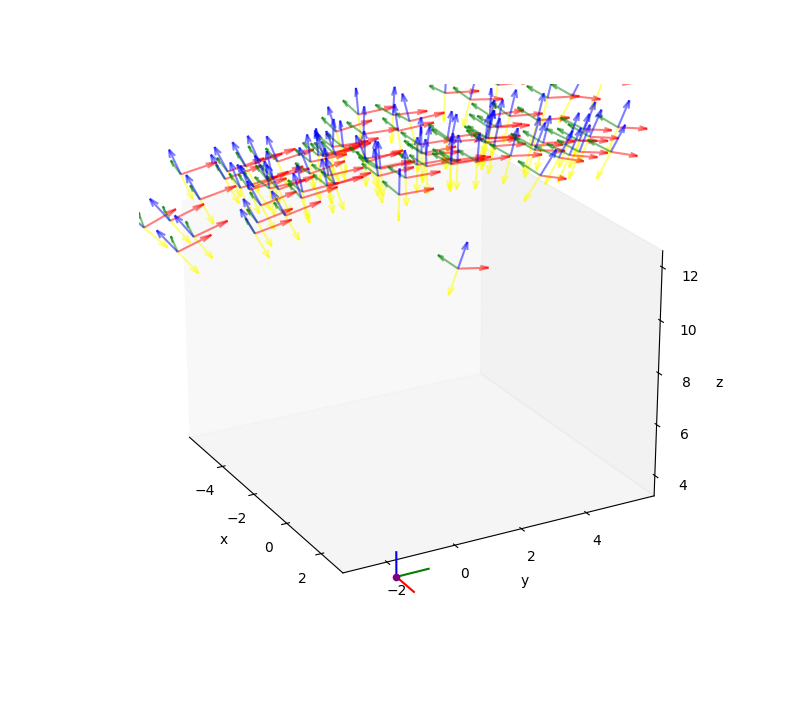

89


In [8]:
#debug coordinate system in <poses>

# #scale poses to unit cube
# radii = np.sqrt(np.sum(poses[:,:3,-1]**2, axis = 1))
# print(max(radii))
# poses[:,:3,-1] = 3*poses[:,:3,-1]/max(radii)


# camera_centers = ax.scatter3D(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1])
headings = poses[:,:3,:3] @ np.array([0,0,-1]) #works

##vedo
# from vedo import *
# from ipyvtklink.viewer import ViewInteractiveWidget

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
# disp=[]
# disp.append(Points(poses[:,:3,-1], c = "#CB2314"))
# disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "#CB2314"))
# disp.append(Points(np.array([[0,0,0]]), c = 'black'))

# plt.show(disp, "camera poses")
# ViewInteractiveWidget(plt.window)

# mpl:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib notebook
import matplotlib.pyplot as plt
# print(poses[0])
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_zlim([-6,6])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.grid(False)
X, Y, Z = axes3d.get_test_data(0.05)
# ax.contour(X, Y, Z, cmap=cm.coolwarm)  # Plot contour curves

#plot axis
ax.scatter3D(0,0,0, color='purple')
ax.plot([0,1],[0,0],[0,0], color = 'red')
ax.plot([0,0],[0,1],[0,0], color = 'green')
ax.plot([0,0],[0,0],[0,1], color = 'blue')

ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'yellow', alpha = 0.5)
headings = poses[:,:3,:3] @ np.array([1,0,0])
ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'red', alpha = 0.5)
headings = poses[:,:3,:3] @ np.array([0,1,0])
ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'green', alpha = 0.5)
headings = poses[:,:3,:3] @ np.array([0,0,1]) 
ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'blue', alpha = 0.5)
print(len(poses))
plt.show()

In [ ]:
1//0.5

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
# %matplotlib notebook
import matplotlib.pyplot as plt

In [ ]:
images_from_colmap[1].name

In [ ]:
# #verify images are set up correclty
# plt.imshow(images[55])
# # plt.imshow(images_from_colmap[1])

# print(poses[55])

# print(R.from_matrix(poses[55,:3,:3]).as_euler('xyz'))

# TinyNeRF Implementation

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 16
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #D=8, W=256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32): #was 1024*32
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
#     print("\n z_vals: \n", z_vals)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
#     print("\n test: \n", tf.shape(rays_o[...,None,:]))
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
#     print("\n pts_flat shape: \n", tf.shape(pts_flat)) # <---------------- This is the OOM Bottleneck
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

In [ ]:
model = init_model(D=8, W=256)
# model = init_model(D=8, W=512) #debug
optimizer = tf.keras.optimizers.Adam(5e-4)
# optimizer = tf.keras.optimizers.Adam() 

N_samples = 8 #32 #64 #decrease as needed for VRAM(?)
N_iters = 10_000 #10_000
psnrs = []
iternums = []
i_plot = 100 #25

import time
t = time.time()
for i in range(N_iters+1):
#     print(i, "-------------------------------")
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    
    rays_o, rays_d = get_rays(H, W, focal, pose)
    rays_o = tf.cast(rays_o, tf.float32)
    rays_d = tf.cast(rays_d, tf.float32)
    
#     print("\n rays_o, rays_d \n", tf.shape(rays_o), tf.shape(rays_d))
    
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0., far=32., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rays_o = tf.cast(rays_o, tf.float32)
        rays_d = tf.cast(rays_d, tf.float32)
        
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0., far=32., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [ ]:
# model = init_model(D=8, W=256)
# print(model.summary())

print(tf.shape(rays_o))
print(tf.shape(rays_o[...,None,:]))

# test = np.ones([1000,1000,3])
# print(np.shape(test))
# test = test[...,None,:]
# print(np.shape(test))

In [ ]:
a = tf.constant([1,2,3])
b = tf.constant([4,5,6])
x, y = tf.meshgrid(a,b)
print(x, "\n", y)

# Alternate keras NeRF implementation 
https://keras.io/examples/vision/nerf/ 

In [ ]:
import glob
import imageio
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 1 #5
NUM_SAMPLES = 32 #16 #number of sample points along a ray
POS_ENCODE_DIMS = 16 #16
EPOCHS = 50_000
num_images = len(images)
plt.imshow(images[np.random.randint(low=0, high=num_images)])

In [ ]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near= 0., #was 2.
        far= 128.,  #was 6. for Lego, tried 32 for bike, 8 for desk
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)

In [ ]:
# Create the training split.
split_index = int(num_images * 0.8) #was this
# split_index = int(num_images * 0.9) #really want to max out limited training data

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_images, tf.float32)) #need to convert train data
train_pose_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_poses, tf.float32))

train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_images, tf.float32))
val_pose_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_poses, tf.float32))
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [ ]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)

        if epoch%10 == 0:
            test_recons_images, depth_maps = render_rgb_depth(
                model=self.model.nerf_model,
                rays_flat=test_rays_flat,
                t_vals=test_t_vals,
                rand=True,
                train=False,
            )
            # Plot the rgb, depth and the loss plot.
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
            ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
            ax[0].set_title(f"Predicted Image: {epoch:03d}")

            ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
            ax[1].set_title(f"Depth Map: {epoch:03d}")

            ax[2].plot(loss_list)
#             ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
            ax[2].set_title(f"Loss Plot: {epoch:03d}")

            fig.savefig(f"images/{epoch:03d}.png")
            plt.show()
            plt.close()
            
            model.save_weights("models/bike.ckpt") #save checkpoint
#             model.save_weights("models/desk.ckpt") #save checkpoint


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(5e-3), loss_fn=keras.losses.MeanSquaredError()
)
#1e-5 too slow for checkpoint

# model.load_weights("models/bike.ckpt")

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")
    
model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // BATCH_SIZE,
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")


# render animation

In [ ]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0.0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 60, endpoint=False))):
# for index, fwd_trans in tqdm(enumerate(np.linspace(-8, -5, 60, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(0,theta, -8)
#     c2w = pose_spherical(0, 180, fwd_trans)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2., far=32., num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)


In [ ]:
# model.save("models/bike.keras") #doesn't work with subclassed model
# tf.keras.saving.save_model(model, "models/bike.keras") #not in tf2.X

# model.save_weights("models/bike.ckpt")

In [ ]:
# print(model.summary())
# model.load_weights("models/bike.ckpt")

# Inference

In [ ]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# print(tf.shape(test_t_vals))
print(tf.shape(test_imgs))
# print(len(ori_img))

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(
        keras.utils.array_to_img(depth_map[..., None]), cmap="inferno"
    )
    ax[2].set_title("Depth Map")


# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
#     rays_o, rays_d = get_rays(500, 500, focal, c2w[:3,:4]) #test upscaling
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
#     plt.figure(2, figsize=(20,6))
    plt.figure(2)
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [0, -180., 180]],
    ['phi', [0, -180., 180]],
    ['radius', [4., 1., 10.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot